<a href="https://colab.research.google.com/github/dolevi101/PPKMeans/blob/main/Privacy_Preserving_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tenseal
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import copy
import tenseal as ts
import time
import numpy as np
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import random

In [19]:
def real_kmeans(n_clusters, data):
    print("real_kmeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data).reshape(-1, 1))
    labels_data = [0]*len(data)
    labels_centers = [1]*len(kmeans.cluster_centers_)
    labels = labels_data + labels_centers
    X = data + list(kmeans.cluster_centers_)  
    print_fig(X, labels, "real kmeans")
    centers = [item[0] for item in kmeans.cluster_centers_]
    return centers

In [5]:
def get_ckks_context():
  # parameters
  #poly_mod_degree = 2**12
  poly_mod_degree = 2**13
  #coeff_mod_bit_sizes = [40, 20, 40]
  coeff_mod_bit_sizes = [35, 25, 25, 25, 25, 25, 25, 25, 25, 35]
  # create TenSEALContext
  context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  # scale of ciphertext to use
  #context.global_scale = 2 ** 20
  context.global_scale = 2 ** 25
  # this key is needed for doing dot-product operations
  context.generate_galois_keys()
  return context


def get_other_context():
  # parameters
  #poly_mod_degree = 8192
  poly_mod_degree = 16384
  #poly_mod_degree = 32768
  #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
  coeff_mod_bit_sizes = [60,35,35,35,35,35,35,35,35,35,60]
  #coeff_mod_bit_sizes = [60,50,50,50,50,50,50,50,50,50,50,50,60]
  print("sum of coeff_mod_bit_sizes=", sum(coeff_mod_bit_sizes))
  # create TenSEALContext
  ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  ctx_training.global_scale = 2 ** 35
  ctx_training.generate_galois_keys()
  return ctx_training


def print_fig(X, centers_colors, plot_name):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    axs.scatter(X, [0]*len(X), c=centers_colors)
    axs.set_title(plot_name)
    fig.show()

In [11]:
def our_kmeans(data, centers, n, p, iterations):
    print("our_kmeans...")
    start = time.time()
    probs, p_values_sum = prob_to_be_in_center(data, centers,p,n)
    new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
    end = time.time()

    print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))

    for i in range(1, iterations):
        start = time.time()
        probs, p_values_sum = prob_to_be_in_center(data, new_centers,p,n)
        new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
        end = time.time()
        print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))

    labels_data = [0]*len(data)
    labels_centers = [1]*len(new_centers)
    labels = labels_data + labels_centers
    X = data + new_centers    
    print_fig(X, labels, "our kmeans")
    return new_centers

In [12]:
def encrypted_kmeans(data, centers, n, p, iterations):
    print("encrypted_kmeans...")
    context = get_other_context()
    enc_data = [ts.ckks_tensor(context, [item]) for item in data]
    enc_centers = [ts.ckks_tensor(context, [item]) for item in centers]
    
    start = time.time()
    res_probs, res_p_values_sum = prob_to_be_in_center(enc_data, enc_centers,p,n)
    probs, p_values_sum = [item.decrypt().tolist()[0] for item in res_probs], [item.decrypt().tolist()[0] for item in res_p_values_sum]
    
    new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
    end = time.time()

    print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))

    for i in range(1, iterations):
        start = time.time()
        enc_data = [ts.ckks_tensor(context, [item]) for item in data]
        enc_centers = [ts.ckks_tensor(context, [item]) for item in new_centers]
        res_probs, res_p_values_sum = prob_to_be_in_center(enc_data, enc_centers,p,n)
        probs = [item.decrypt().tolist()[0] for item in res_probs]
        p_values_sum = [item.decrypt().tolist()[0] for item in res_p_values_sum]
        new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
        end = time.time()
        print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))

    labels_data = [0]*len(data)
    labels_centers = [1]*len(new_centers)
    labels = labels_data + labels_centers
    X = data + new_centers    
    print_fig(X, labels, "encrypted kmeans")
    return new_centers

In [8]:
def max_with_lp(distances, p=20):
  #alpha = ts.plain_tensor(1/p)
  #alpha = 1/p
  #return taylor_series_sqrt_x_plus_1_alpha((x1**p + x2**p+ x3**p+ x4**p) - 1, alpha)
  result_pow = [dist**p for dist in distances]
  return sum(result_pow)
  #return (x1**p + x2**p+ x3**p+ x4**p)


def taylor_series_sqrt_x_plus_1_alpha(x, a):
  sum_elements = 1
  #print("a={}, x={}".format(a,x.data))
  sum_elements += x*a
  sum_elements += 0.5*a*(a-1)*(x**2)
  sum_elements += (1/6)*a*(a-1)*(a-2)*(x**3)
  return sum_elements


def distance(a, b):
  return (a-b)**2


def get_p_value(x, max_val, p,n):
  #approx = approx_to_1_div_x(max_val,n)
  approx = inverse(max_val, n)
  xp = x**p
  #print("xp = {} approx = {}, real = {}".format(xp.decrypt().tolist()[0], approx.decrypt().tolist()[0], (1/(max_val.decrypt().tolist()[0]))))
  #print("x = {}, max_val = {}".format(x, max_val))
  #return xp/max_val
  prob = xp * approx
  return prob
  

#converges only when 0<x<2
def approx_to_1_div_x(x, n):
  #print("x in approx_to_1_div_x is: {}".format(x))
  mul = 1
  for i in range(n):
    mul *= (1+(1-x)**(2**i))
  #print("1/{} = {}".format(x,mul))
  return mul


def inverse(x, n):
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b**2
        a = a*(1 + b)
    return a


def normalize_distances(data, centers, n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  dis_before_norm = []
  sum_inv_dis = 0
  for x in data:
      temp_dis_before_norm = []
      for c in centers:
            dis = distance(x, c)
            inv_dis = inverse(dis, n)
            #print("inv_dis = {}".format(inv_dis))
            sum_inv_dis += inv_dis
            temp_dis_before_norm.append(inv_dis)
      dis_before_norm.append(temp_dis_before_norm)
  print(dis_before_norm)
  normalized_dis = []
  for i in range(num_of_points):
    normalized_dis_per_point = []
    for j in range(num_of_centers):
      denominator = inverse(sum_inv_dis, n)
      print("inverse(sum_inv_dis,n) = ",denominator)
      alt_den = 1/sum_inv_dis
      print("1/sum_inv_dis = ",alt_den)
      dis_after_norm = dis_before_norm[i][j] * denominator
      print("dis_after_norm = {}".format(dis_after_norm))
      normalized_dis_per_point.append(dis_after_norm)
    normalized_dis.append(normalized_dis_per_point)

  return normalized_dis


In [9]:
def prob_to_be_in_center(data, centers, p,n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  distances_div_k = []
  sum_distance_p_from_point = []
  for x in data:
      temp_dis_div_k = []
      temp_sum_div_k = 0
      for c in centers:
            dis = distance(x, c)
            inv = 1/num_of_centers
            dis_div_k = dis * inv
            temp_dis_div_k.append(dis_div_k)
            temp_sum_div_k += dis_div_k
            #print("x = {}, c = {}, dis = {}, dis_div_k = {}, temp_sum_div_k = {}".format(x,c, dis, dis_div_k, temp_sum_div_k))

      all_dis_div_k_per_point = [(temp_sum_div_k - item) for item in temp_dis_div_k]
      #print("all_dis_div_k_per_point = ",all_dis_div_k_per_point)
      distances_div_k.append(all_dis_div_k_per_point)
      sum_distance_p_from_point.append(sum([item**p for item in all_dis_div_k_per_point]))
    

  distances = distances_div_k

  probs = []
  p_values_sum = []
  for i in range(num_of_centers):
    probs_sum = 0
    p_values_sum_per_center = 0
    for j in range(num_of_points):
        #print("distances[j][i] = {}, sum_distance_p_from_point[j] = {}".format(distances[j][i], sum_distance_p_from_point[j]))
        p_value = get_p_value(distances[j][i], sum_distance_p_from_point[j], p,n)
        probs_sum += data[j] * p_value
        p_values_sum_per_center += p_value
        if to_print:
          print("@@@@@")
          if is_pp_case:
            #print("point: {}, center: {}, 1 - p_value: {}".format(data[j].decrypt().tolist()[0], centers[i].decrypt().tolist()[0], 1 - p_value.decrypt().tolist()[0]))
            print("point: {}, center: {}, p_value: {}".format(data[j].decrypt().tolist()[0], centers[i].decrypt().tolist()[0], p_value.decrypt().tolist()[0]))
          else:
            #print("point: {}, center: {}, 1 - p_value: {}".format(data[j], centers[i], 1 - p_value))
            print("point: {}, center: {}, p_value: {}".format(data[j], centers[i], p_value))
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)
    print("finished center {}/{}".format(i+1, num_of_centers))
  return probs, p_values_sum


In [15]:
def compare_centers(c1, c2):
  c1 = sorted(c1)
  c2 = sorted(c2)
  result = []
  for i in range(len(c1)):
    result.append(abs(c1[i]-c2[i]))
  return result, sum(result)

p =  0
our_kmeans...
@@@@@
point: 0.1, center: 0.2, p_value: -21845.0
@@@@@
point: 0.2, center: 0.2, p_value: -21845.0
@@@@@
point: 0.5, center: 0.2, p_value: -21845.0
@@@@@
point: 0.8, center: 0.2, p_value: -21845.0
@@@@@
point: 0.9, center: 0.2, p_value: -21845.0
@@@@@
point: 0.15, center: 0.2, p_value: -21845.0
@@@@@
point: 0.6, center: 0.2, p_value: -21845.0
@@@@@
point: 0.55, center: 0.2, p_value: -21845.0
finished center 1/3
@@@@@
point: 0.1, center: 0.48, p_value: -21845.0
@@@@@
point: 0.2, center: 0.48, p_value: -21845.0
@@@@@
point: 0.5, center: 0.48, p_value: -21845.0
@@@@@
point: 0.8, center: 0.48, p_value: -21845.0
@@@@@
point: 0.9, center: 0.48, p_value: -21845.0
@@@@@
point: 0.15, center: 0.48, p_value: -21845.0
@@@@@
point: 0.6, center: 0.48, p_value: -21845.0
@@@@@
point: 0.55, center: 0.48, p_value: -21845.0
finished center 2/3
@@@@@
point: 0.1, center: 0.75, p_value: -21845.0
@@@@@
point: 0.2, center: 0.75, p_value: -21845.0
@@@@@
point: 0.5, center: 0.75, p_value: -2

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,



point: 0.15, center: 0.5429312151504538, p_value: 0.2370770072392515
@@@@@
point: 0.6, center: 0.5429312151504538, p_value: 0.28283463936041525
@@@@@
point: 0.55, center: 0.5429312151504538, p_value: 0.19474355397561857
finished center 3/3
(5/10) centers = [0.35612664056120374, 0.47912071416628593, 0.5339295554936754], Duration: 0.05571603775024414 seconds
@@@@@
point: 0.1, center: 0.35612664056120374, p_value: 0.414486687498849
@@@@@
point: 0.2, center: 0.35612664056120374, p_value: 0.4051561373134975
@@@@@
point: 0.5, center: 0.35612664056120374, p_value: 0.0075839359848968125
@@@@@
point: 0.8, center: 0.35612664056120374, p_value: 0.23181906316357545
@@@@@
point: 0.9, center: 0.35612664056120374, p_value: 0.25625823491261107
@@@@@
point: 0.15, center: 0.35612664056120374, p_value: 0.4164016646889473
@@@@@
point: 0.6, center: 0.35612664056120374, p_value: 0.06974151888991685
@@@@@
point: 0.55, center: 0.35612664056120374, p_value: 0.022868390295077725
finished center 1/3
@@@@@
point

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,



(4/10) centers = [0.1925689633420774, 0.4473604546129165, 0.7974191132923288], Duration: 0.01711416244506836 seconds
@@@@@
point: 0.1, center: 0.1925689633420774, p_value: 0.40171981011857344
@@@@@
point: 0.2, center: 0.1925689633420774, p_value: 0.24281408719846242
@@@@@
point: 0.5, center: 0.1925689633420774, p_value: 0.0141803710229156
@@@@@
point: 0.8, center: 0.1925689633420774, p_value: 0.020059563228044516
@@@@@
point: 0.9, center: 0.1925689633420774, p_value: 0.04476763066974199
@@@@@
point: 0.15, center: 0.1925689633420774, p_value: 0.3222313043526003
@@@@@
point: 0.6, center: 0.1925689633420774, p_value: 0.006443917323885372
@@@@@
point: 0.55, center: 0.1925689633420774, p_value: 0.008708820929920801
finished center 1/3
@@@@@
point: 0.1, center: 0.4473604546129165, p_value: 0.2670637397686013
@@@@@
point: 0.2, center: 0.4473604546129165, p_value: 0.17699909161289828
@@@@@
point: 0.5, center: 0.4473604546129165, p_value: 0.0570414315928908
@@@@@
point: 0.8, center: 0.44736045

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


@@@@@
point: 0.1, center: 0.8594281087353797, p_value: 0.0006050049288531874
@@@@@
point: 0.2, center: 0.8594281087353797, p_value: 7.163527606278445e-05
@@@@@
point: 0.5, center: 0.8594281087353797, p_value: 0.0011505804253203827
@@@@@
point: 0.8, center: 0.8594281087353797, p_value: 0.09689463439752873
@@@@@
point: 0.9, center: 0.8594281087353797, p_value: 0.23875042679849237
@@@@@
point: 0.15, center: 0.8594281087353797, p_value: 0.00021036856756741454
@@@@@
point: 0.6, center: 0.8594281087353797, p_value: 0.007133822646357439
@@@@@
point: 0.55, center: 0.8594281087353797, p_value: 0.003018677551323094
finished center 3/3
(8/10) centers = [0.15590665129090178, 0.41702556827636084, 0.8596409259245917], Duration: 0.05611467361450195 seconds
@@@@@
point: 0.1, center: 0.15590665129090178, p_value: 0.1604932135127517
@@@@@
point: 0.2, center: 0.15590665129090178, p_value: 0.06295819945206141
@@@@@
point: 0.5, center: 0.15590665129090178, p_value: 0.0014899257923196342
@@@@@
point: 0.8, c

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


point: 0.55, center: 0.44439860161745365, p_value: 0.0011667858573541708
finished center 2/3
@@@@@
point: 0.1, center: 0.8748647950923994, p_value: 3.9320727993459104e-05
@@@@@
point: 0.2, center: 0.8748647950923994, p_value: 3.2543679597597492e-06
@@@@@
point: 0.5, center: 0.8748647950923994, p_value: 6.731499300712409e-05
@@@@@
point: 0.8, center: 0.8748647950923994, p_value: 0.020273240876814307
@@@@@
point: 0.9, center: 0.8748647950923994, p_value: 0.07410364439799223
@@@@@
point: 0.15, center: 0.8748647950923994, p_value: 1.1030226901275976e-05
@@@@@
point: 0.6, center: 0.8748647950923994, p_value: 0.0006535342372245324
@@@@@
point: 0.55, center: 0.8748647950923994, p_value: 0.00022085404715791138
finished center 3/3
(4/10) centers = [0.13377133316444476, 0.4218221832643412, 0.8751540099223895], Duration: 0.030565500259399414 seconds
@@@@@
point: 0.1, center: 0.13377133316444476, p_value: 0.04697549433986605
@@@@@
point: 0.2, center: 0.13377133316444476, p_value: 0.012720857398695

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


RESULT for p =  4
p =  5
our_kmeans...
@@@@@
point: 0.1, center: 0.2, p_value: 0.0038464263643879647
@@@@@
point: 0.2, center: 0.2, p_value: 0.0005277486299192041
@@@@@
point: 0.5, center: 0.2, p_value: 6.482846470595373e-08
@@@@@
point: 0.8, center: 0.2, p_value: 8.356487367672929e-07
@@@@@
point: 0.9, center: 0.2, p_value: 2.0391506532306244e-05
@@@@@
point: 0.15, center: 0.2, p_value: 0.001491169269179354
@@@@@
point: 0.6, center: 0.2, p_value: 4.504438509650635e-09
@@@@@
point: 0.55, center: 0.2, p_value: 1.2015544133035317e-08
finished center 1/3
@@@@@
point: 0.1, center: 0.48, p_value: 0.0009941586528049334
@@@@@
point: 0.2, center: 0.48, p_value: 0.00016672439346542055
@@@@@
point: 0.5, center: 0.48, p_value: 5.430773970456179e-06
@@@@@
point: 0.8, center: 0.48, p_value: 0.00041180003061468243
@@@@@
point: 0.9, center: 0.48, p_value: 0.002316033014279477
@@@@@
point: 0.15, center: 0.48, p_value: 0.00041178055608934324
@@@@@
point: 0.6, center: 0.48, p_value: 1.3329785959942835e-

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,



@@@@@
point: 0.8, center: 0.12253068682468564, p_value: 2.826261147748306e-07
@@@@@
point: 0.9, center: 0.12253068682468564, p_value: 3.405990147563023e-06
@@@@@
point: 0.15, center: 0.12253068682468564, p_value: 0.001192855170381323
@@@@@
point: 0.6, center: 0.12253068682468564, p_value: 5.1834607693090325e-08
@@@@@
point: 0.55, center: 0.12253068682468564, p_value: 1.1077690929913869e-07
finished center 1/3
@@@@@
point: 0.1, center: 0.4185374763664699, p_value: 0.001246005883106908
@@@@@
point: 0.2, center: 0.4185374763664699, p_value: 0.00026241651187599555
@@@@@
point: 0.5, center: 0.4185374763664699, p_value: 1.37140052053784e-05
@@@@@
point: 0.8, center: 0.4185374763664699, p_value: 0.00022625572148397634
@@@@@
point: 0.9, center: 0.4185374763664699, p_value: 0.0010679571535373855
@@@@@
point: 0.15, center: 0.4185374763664699, p_value: 0.0005695320197302007
@@@@@
point: 0.6, center: 0.4185374763664699, p_value: 1.964816334280672e-05
@@@@@
point: 0.55, center: 0.4185374763664699,

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,



point: 0.15, center: 0.4181143934841961, p_value: 0.00011030650832669417
@@@@@
point: 0.6, center: 0.4181143934841961, p_value: 2.2920406849987633e-06
@@@@@
point: 0.55, center: 0.4181143934841961, p_value: 1.6663067835069661e-06
finished center 2/3
@@@@@
point: 0.1, center: 0.8904638191496583, p_value: 8.146268862526052e-10
@@@@@
point: 0.2, center: 0.8904638191496583, p_value: 9.98417566557966e-12
@@@@@
point: 0.5, center: 0.8904638191496583, p_value: 1.366834698325695e-08
@@@@@
point: 0.8, center: 0.8904638191496583, p_value: 0.00022911903605917785
@@@@@
point: 0.9, center: 0.8904638191496583, p_value: 0.0021980693256420884
@@@@@
point: 0.15, center: 0.8904638191496583, p_value: 7.966295591778172e-11
@@@@@
point: 0.6, center: 0.8904638191496583, p_value: 6.629506514930347e-07
@@@@@
point: 0.55, center: 0.8904638191496583, p_value: 1.0473434470246009e-07
finished center 3/3
(8/10) centers = [0.11892030823573536, 0.41811382410546116, 0.890463792512879], Duration: 0.02493739128112793 

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


@@@@@
point: 0.1, center: 0.892903745274868, p_value: 2.8261382496952694e-11
@@@@@
point: 0.2, center: 0.892903745274868, p_value: 2.0142563946607635e-13
@@@@@
point: 0.5, center: 0.892903745274868, p_value: 7.730223599318647e-10
@@@@@
point: 0.8, center: 0.892903745274868, p_value: 4.8729791007863655e-05
@@@@@
point: 0.9, center: 0.892903745274868, p_value: 0.0006410001695341538
@@@@@
point: 0.15, center: 0.892903745274868, p_value: 2.0509168169780033e-12
@@@@@
point: 0.6, center: 0.892903745274868, p_value: 6.314236326403322e-08
@@@@@
point: 0.55, center: 0.892903745274868, p_value: 7.774546322593824e-09
finished center 3/3
(8/10) centers = [0.11602313348606505, 0.4187553846578313, 0.8929037917228541], Duration: 0.0039043426513671875 seconds
@@@@@
point: 0.1, center: 0.11602313348606505, p_value: 0.00019729440600681195
@@@@@
point: 0.2, center: 0.11602313348606505, p_value: 1.4723687650795865e-05
@@@@@
point: 0.5, center: 0.11602313348606505, p_value: 1.0995056379992104e-09
@@@@@
poi

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


point: 0.2, center: 0.8948084949645652, p_value: 1.1828228335955563e-13
@@@@@
point: 0.5, center: 0.8948084949645652, p_value: 3.2136031868808666e-11
@@@@@
point: 0.8, center: 0.8948084949645652, p_value: 6.057709330682574e-06
@@@@@
point: 0.9, center: 0.8948084949645652, p_value: 0.0001134186963737396
@@@@@
point: 0.15, center: 0.8948084949645652, p_value: 1.1667273630694703e-12
@@@@@
point: 0.6, center: 0.8948084949645652, p_value: 3.5411691590555426e-09
@@@@@
point: 0.55, center: 0.8948084949645652, p_value: 3.647779519485007e-10
finished center 3/3
(4/10) centers = [0.11355959580926786, 0.4218108323223489, 0.8949197828360986], Duration: 0.004839897155761719 seconds
@@@@@
point: 0.1, center: 0.11355959580926786, p_value: 5.117353113833127e-05
@@@@@
point: 0.2, center: 0.11355959580926786, p_value: 2.7801403152172933e-06
@@@@@
point: 0.5, center: 0.11355959580926786, p_value: 6.273029349469545e-11
@@@@@
point: 0.8, center: 0.11355959580926786, p_value: 3.5282974378379507e-11
@@@@@
po

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


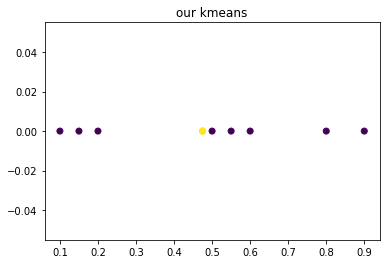

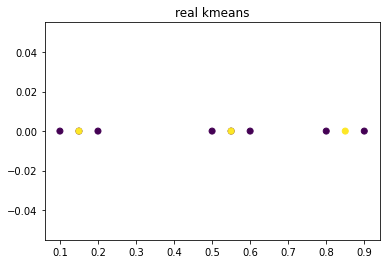

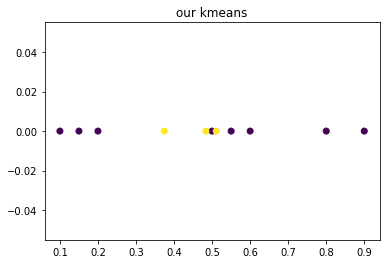

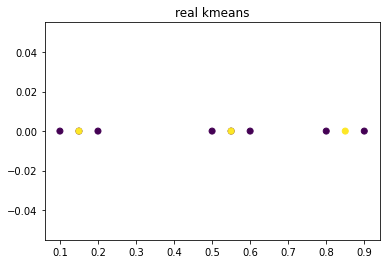

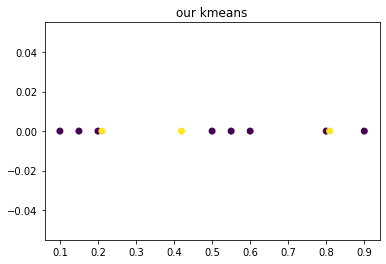

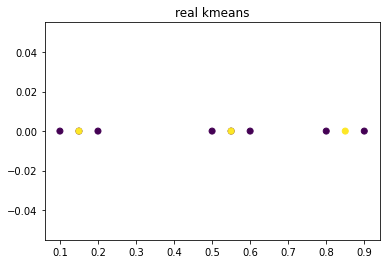

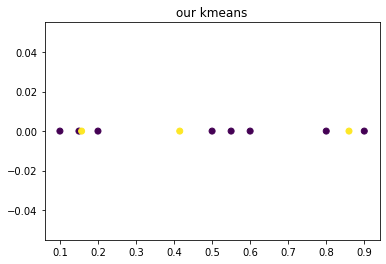

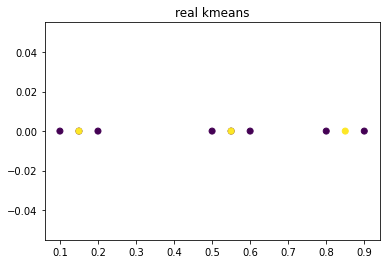

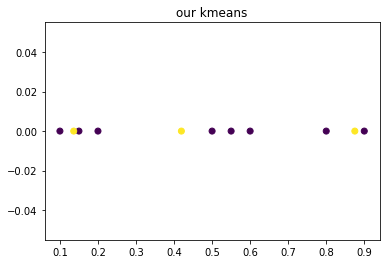

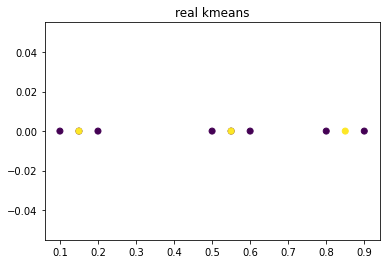

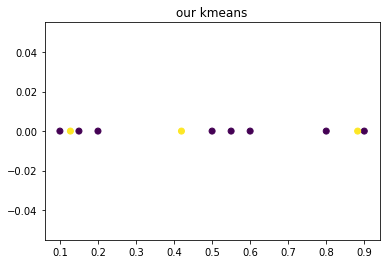

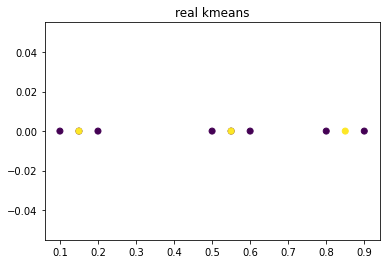

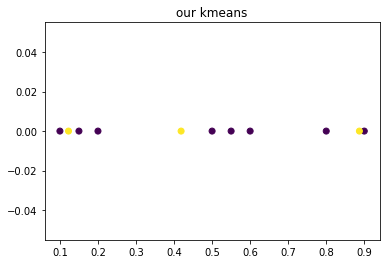

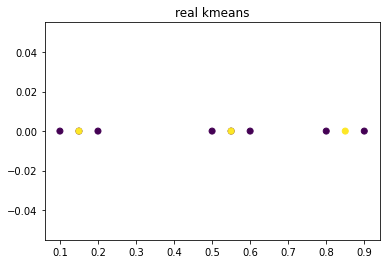

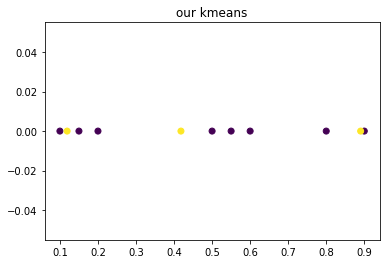

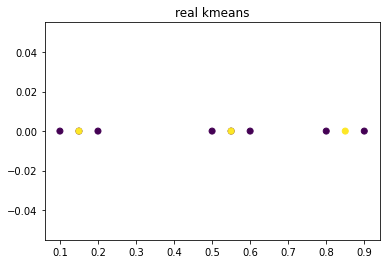

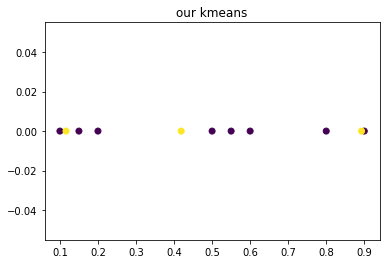

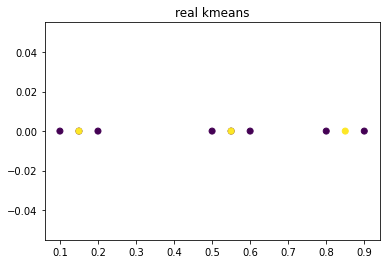

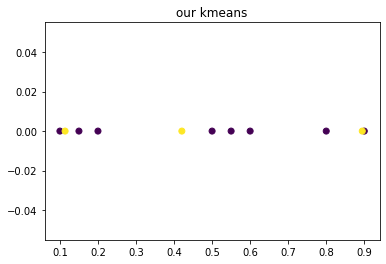

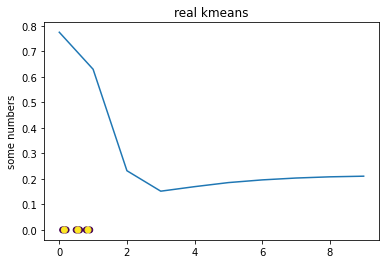

In [27]:
data = [0.1, 0.2, 0.5, 0.8, 0.9, 0.15, 0.6, 0.55]
c1 = 0.2
c2 = 0.48
c3 = 0.75
initial_centers = [c1, c2, c3]

n=3
#p must be even
p=2
iterations = 10
to_print = True

#data = static_data

#is_pp_case = False
#c2 = our_kmeans(data, initial_centers, n, p, iterations)
#c1 = real_kmeans(len(initial_centers), data)
#is_pp_case = True
#c2 = encrypted_kmeans(data, initial_centers, n, p, iterations)
results_over_p = []
for deg in range(0,10):
  print("p = ", deg)
  p = deg
  is_pp_case = False
  c2 = our_kmeans(data, initial_centers, n, p, iterations)
  c1 = real_kmeans(len(initial_centers), data)
  print("RESULT for p = ", deg)
  res, sum_res = compare_centers(c1, c2)
  #print()
  results_over_p.append(sum_res)
plt.plot(results_over_p)
plt.ylabel('some numbers')
plt.show()